## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.layers import Input
from PIL import Image
from glob import glob

### Need if you have GPU rtx 3000 series

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8714652175635595837
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6910041152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7529809116744620152
physical_device_desc: "device: 0, name: GeForce RTX 3070, pci bus id: 0000:0a:00.0, compute capability: 8.6"
]


### Funcs

In [5]:
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
    x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")

    # perform the inverse of the preprocessiing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x
def remove_transparency(image):
    new_image = Image.new("RGBA", image.size, "WHITE")
    new_image.paste(image, (0, 0), image)
    new_image.convert('RGB')
    return new_image

## Treatment

### Load data

In [4]:
data=pd.read_csv("../data/pokedex_(Update_04.21).csv", index_col="Unnamed: 0")

In [5]:
data["name"].replace("Type: Null","Type_null",inplace=True)

In [6]:
data["type_2"].fillna("No_type",inplace=True)

In [7]:
data.columns

Index(['pokedex_number', 'name', 'german_name', 'japanese_name', 'generation',
       'status', 'species', 'type_number', 'type_1', 'type_2', 'height_m',
       'weight_kg', 'abilities_number', 'ability_1', 'ability_2',
       'ability_hidden', 'total_points', 'hp', 'attack', 'defense',
       'sp_attack', 'sp_defense', 'speed', 'catch_rate', 'base_friendship',
       'base_experience', 'growth_rate', 'egg_type_number', 'egg_type_1',
       'egg_type_2', 'percentage_male', 'egg_cycles', 'against_normal',
       'against_fire', 'against_water', 'against_electric', 'against_grass',
       'against_ice', 'against_fight', 'against_poison', 'against_ground',
       'against_flying', 'against_psychic', 'against_bug', 'against_rock',
       'against_ghost', 'against_dragon', 'against_dark', 'against_steel',
       'against_fairy'],
      dtype='object')

In [8]:
data_to_train = data[["name","generation"]].copy()
data_dumm = pd.get_dummies(data["type_1"]).assign(No_type = 0)+pd.get_dummies(data["type_2"])
data_to_train[data_dumm.columns] = data_dumm

In [9]:
classes = data_to_train.columns[2:]
n_class = len(classes)

In [10]:
pokemon_s = data_to_train["name"]

In [11]:
pokemon_test = ["Falinks","Florges","Sudowoodo","Gyarados","Lugia","Meloetta Aria Forme","Meloetta Pirouette Forme"] +list(data_to_train["name"].sample(frac=.30,random_state=0))
pokemon_test = set(pokemon_test)

### Image treatment

In [ ]:
X_train = []
y_train = []
X_test = []
y_test = []
names_train = []
names_test  = []
for pokemon in pokemon_s:
    images_pokemon = (map(Image.open, glob(f"../imgs/pokemon/{pokemon}/*")))
    images_pokemon = list(images_pokemon)
    images_pokemon = [np.array(img.resize((128,128)).convert('RGB')) for img in images_pokemon]
    # images_pokemon = [img[:,:,:3] for img in images_pokemon if len(img.shape)==3]
    images_pokemon = [preprocess_input(img) for img in images_pokemon]
    labels = [list(data_to_train.loc[data_to_train["name"]==pokemon,classes].values[0])]*len(images_pokemon)
    if pokemon in pokemon_test:
        names_test += [pokemon]*len(images_pokemon)
        X_test.extend(images_pokemon)
        y_test.extend(labels)
    else:
        names_train += [pokemon]*len(images_pokemon)
        X_train.extend(images_pokemon)
        y_train.extend(labels)

In [3]:
X_train = np.load("../data/X_train.npy",)
X_test = np.load("../data/X_test.npy",)
y_train = np.load("../data/y_train.npy",)
y_test = np.load("../data/y_test.npy",)

### Save Data

In [ ]:
np.save("../data/X_train",np.array(X_train))
np.save("../data/X_test",np.array(X_test))
np.save("../data/y_train",np.array(y_train))
np.save("../data/y_test",np.array(y_test))
np.save("../data/names_train",names_train)
np.save("../data/names_test",names_test)

### Show data

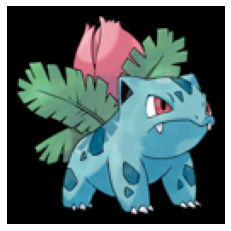

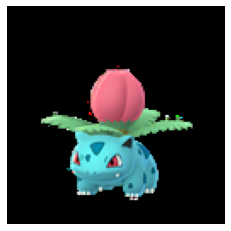

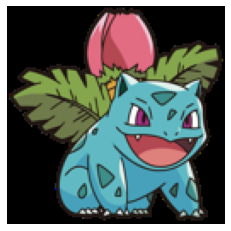

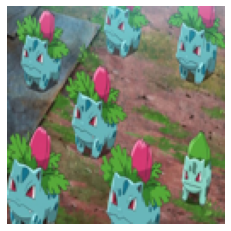

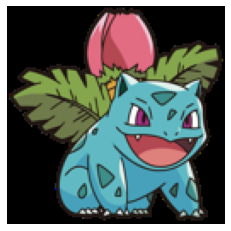

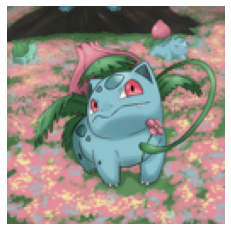

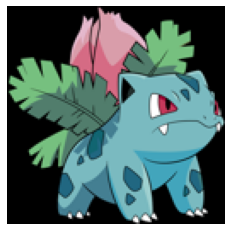

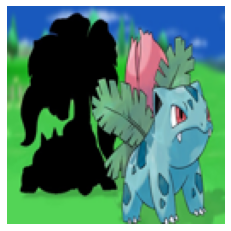

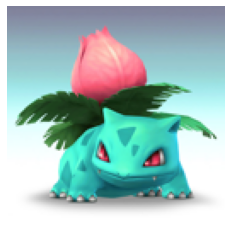

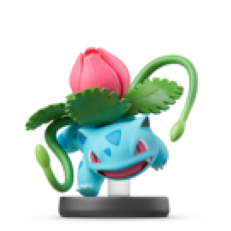

In [6]:
for img in X_test[:10]:
    plt.imshow(deprocess_img(img))
    plt.axis("off")
    plt.show()

In [14]:
new_input = Input(shape=(128,128, 3))

In [15]:
from  tensorflow.keras.optimizers import SGD,Adam
from  tensorflow.keras.layers import GlobalAveragePooling2D,Dense
from  tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint

### Load VGG16

In [16]:
model = VGG16(    include_top=False,
    weights="imagenet",
    input_tensor=new_input,
    input_shape=None,
    pooling=None,
    classes=n_class,
    classifier_activation='sigmoid',
)

for layer in model.layers:
    layer.trainable = False

In [17]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [18]:
top_model = model.output

top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024,activation="relu")(top_model)
top_model = Dense(512,activation="relu")(top_model)
top_model = Dense(n_class,activation = "sigmoid")(top_model)


In [19]:
model = Model(inputs = model.input , outputs = top_model)

### Compile model

In [20]:
model.compile(loss='binary_crossentropy',
                  optimizer = Adam(),
                  metrics=['acc',"AUC"])

In [21]:
model_checkpoint_callback = ModelCheckpoint(
    filepath="../data/checks/checkpoint.h5",
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


### Train

In [22]:
history  = model.fit(X_train, y_train , batch_size=64, epochs =200,validation_data = (X_test,y_test), callbacks = [model_checkpoint_callback])

Epoch 1/200
57/57 [==============================] - 43s 477ms/step - loss: 0.7694 - acc: 0.1713 - auc: 0.5982 - val_loss: 0.3141 - val_acc: 0.2368 - val_auc: 0.6495
Epoch 2/200
57/57 [==============================] - 8s 142ms/step - loss: 0.3091 - acc: 0.2208 - auc: 0.6587 - val_loss: 0.3132 - val_acc: 0.2368 - val_auc: 0.6431
Epoch 3/200
57/57 [==============================] - 8s 141ms/step - loss: 0.3087 - acc: 0.2148 - auc: 0.6603 - val_loss: 0.3125 - val_acc: 0.2368 - val_auc: 0.6571
Epoch 4/200
57/57 [==============================] - 8s 142ms/step - loss: 0.3087 - acc: 0.2029 - auc: 0.6650 - val_loss: 0.3108 - val_acc: 0.2368 - val_auc: 0.6528
Epoch 5/200
57/57 [==============================] - 8s 141ms/step - loss: 0.3055 - acc: 0.1990 - auc: 0.6791 - val_loss: 0.3088 - val_acc: 0.2368 - val_auc: 0.6727
Epoch 6/200
57/57 [==============================] - 8s 139ms/step - loss: 0.3050 - acc: 0.1966 - auc: 0.6788 - val_loss: 0.3106 - val_acc: 0.2156 - val_auc: 0.6712
Epoch 7/2

57/57 [==============================] - 8s 141ms/step - loss: 0.0107 - acc: 0.5505 - auc: 0.9993 - val_loss: 0.9756 - val_acc: 0.1944 - val_auc: 0.6755
Epoch 100/200
57/57 [==============================] - 8s 141ms/step - loss: 0.0127 - acc: 0.5372 - auc: 0.9992 - val_loss: 0.9177 - val_acc: 0.1950 - val_auc: 0.6826
Epoch 101/200
57/57 [==============================] - 8s 141ms/step - loss: 0.0196 - acc: 0.5200 - auc: 0.9984 - val_loss: 0.8834 - val_acc: 0.1988 - val_auc: 0.6791
Epoch 102/200
57/57 [==============================] - 8s 141ms/step - loss: 0.0433 - acc: 0.4930 - auc: 0.9937 - val_loss: 0.7486 - val_acc: 0.1757 - val_auc: 0.6728
Epoch 103/200
57/57 [==============================] - 8s 141ms/step - loss: 0.0300 - acc: 0.5245 - auc: 0.9973 - val_loss: 0.8250 - val_acc: 0.1826 - val_auc: 0.6741
Epoch 104/200
57/57 [==============================] - 8s 141ms/step - loss: 0.0201 - acc: 0.5741 - auc: 0.9982 - val_loss: 0.7607 - val_acc: 0.1776 - val_auc: 0.6721
Epoch 105/20

57/57 [==============================] - 8s 140ms/step - loss: 0.0297 - acc: 0.5133 - auc: 0.9971 - val_loss: 0.7932 - val_acc: 0.2044 - val_auc: 0.6805
Epoch 198/200
57/57 [==============================] - 8s 139ms/step - loss: 0.0173 - acc: 0.5261 - auc: 0.9987 - val_loss: 0.7616 - val_acc: 0.2125 - val_auc: 0.6776
Epoch 199/200
57/57 [==============================] - 8s 139ms/step - loss: 0.0117 - acc: 0.5704 - auc: 0.9994 - val_loss: 0.8944 - val_acc: 0.2137 - val_auc: 0.6714
Epoch 200/200
57/57 [==============================] - 8s 140ms/step - loss: 0.0088 - acc: 0.5496 - auc: 0.9995 - val_loss: 0.8119 - val_acc: 0.2056 - val_auc: 0.6796


In [27]:
model.load_weights("../data/checks/checkpoint.h5")

In [63]:
from sklearn.metrics import f1_score, classification_report,roc_auc_score

In [38]:

class_to_labels= dict(enumerate(classes))

In [69]:
data_train_real = pd.DataFrame(y_train,columns = classes)
data_train_pred = pd.DataFrame(model.predict(X_train).round(2),columns = classes)

In [70]:
for class_ in classes:
    print(f"{class_} Roc: ", round(roc_auc_score(data_test_real[class_] ,data_test_pred[class_]), 4))
    print(f"{class_} F1: ", round(f1_score(data_test_real[class_] ,data_test_pred[class_].round()), 4),"\n\n")

Bug Roc:  0.6211
Bug F1:  0.2511 


Dark Roc:  0.6421
Dark F1:  0.2632 


Dragon Roc:  0.6343
Dragon F1:  0.2893 


Electric Roc:  0.6633
Electric F1:  0.2677 


Fairy Roc:  0.5634
Fairy F1:  0.1333 


Fighting Roc:  0.6038
Fighting F1:  0.2195 


Fire Roc:  0.6828
Fire F1:  0.3721 


Flying Roc:  0.6671
Flying F1:  0.3333 


Ghost Roc:  0.627
Ghost F1:  0.3008 


Grass Roc:  0.7597
Grass F1:  0.5014 


Ground Roc:  0.5692
Ground F1:  0.1313 


Ice Roc:  0.6178
Ice F1:  0.0877 


No_type Roc:  0.5837
No_type F1:  0.522 


Normal Roc:  0.6607
Normal F1:  0.341 


Poison Roc:  0.6385
Poison F1:  0.2367 


Psychic Roc:  0.6239
Psychic F1:  0.2295 


Rock Roc:  0.5893
Rock F1:  0.1609 


Steel Roc:  0.6052
Steel F1:  0.2048 


Water Roc:  0.6957
Water F1:  0.3691 




In [71]:
data_test_real = pd.DataFrame(y_test,columns = classes)
data_test_pred = pd.DataFrame(model.predict(X_test).round(2),columns = classes)

In [72]:
for class_ in classes:
    print(f"{class_} Roc: ", round(roc_auc_score(data_test_real[class_] ,data_test_pred[class_]), 4))
    print(f"{class_} F1: ", round(f1_score(data_test_real[class_] ,data_test_pred[class_].round()), 4),"\n\n")

Bug Roc:  0.6211
Bug F1:  0.2511 


Dark Roc:  0.6421
Dark F1:  0.2632 


Dragon Roc:  0.6343
Dragon F1:  0.2893 


Electric Roc:  0.6633
Electric F1:  0.2677 


Fairy Roc:  0.5634
Fairy F1:  0.1333 


Fighting Roc:  0.6038
Fighting F1:  0.2195 


Fire Roc:  0.6828
Fire F1:  0.3721 


Flying Roc:  0.6671
Flying F1:  0.3333 


Ghost Roc:  0.627
Ghost F1:  0.3008 


Grass Roc:  0.7597
Grass F1:  0.5014 


Ground Roc:  0.5692
Ground F1:  0.1313 


Ice Roc:  0.6178
Ice F1:  0.0877 


No_type Roc:  0.5837
No_type F1:  0.522 


Normal Roc:  0.6607
Normal F1:  0.341 


Poison Roc:  0.6385
Poison F1:  0.2367 


Psychic Roc:  0.6239
Psychic F1:  0.2295 


Rock Roc:  0.5893
Rock F1:  0.1609 


Steel Roc:  0.6052
Steel F1:  0.2048 


Water Roc:  0.6957
Water F1:  0.3691 


